# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from EMP.metrics import empCreditScoring
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
import io
import shap

# Import and Checking DF

In [2]:
df = catalog.load("scoring_data_raw")

df.info()
df.describe(include='all')

[05/08/25 18:24:17] INFO     Loading data from scoring_data_raw (CSVDataset)...                 ]8;id=82127;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=445067;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packages\kedro\io\data_catalog.py#401\401]8;;\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5708,5681,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
unique,NaN,NaN,NaN,NaN,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,DebtCon,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,3928,2388,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.199497,18607.969799,73760.817200,101776.048741,NaN,NaN,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,NaN,NaN,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,NaN,NaN,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,NaN,NaN,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,NaN,NaN,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141


In [3]:
# Inspect DF
df.info()
df.describe(include='all')

df.duplicated().sum()

df.isna().sum().rename_axis('variable').reset_index(name='missing_count')

for col in df.columns:
    print(f"Value counts for column: {col}")
    print(df[col].value_counts())
    print("-" * 40)

## Basic Exploratory Data Analysis (EDA)
# Basic Info
print("Dataset Info")
print(df.info())

print("\nSummary Statistics")
print(df.describe(include='all'))

# Check for missing values
print("\nMissing Value")
df.isna().sum()

# Count missing values per row
df['missing_count'] = df.isnull().sum(axis=1)

# Show rows with most missing data
df.sort_values('missing_count', ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB
Value counts for column: BAD
BAD
0    4771
1    1189
Name: count, dtype: int64
----------------------------------------
Value counts for column: LOAN
LOAN
15000    105
10000     81
20000     74
25000     73
12000     69
        ... 
1100       1
89000      1


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,missing_count
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
1405,0,10800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11
51,0,3100,NaN,70400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
333,0,6100,NaN,47400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
112,0,4400,NaN,60250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,0,14900,36120.0,57095.0,DebtCon,ProfExe,4.0,0.0,0.0,239.023675,1.0,35.0,38.171624,0
2518,0,15000,80988.0,97404.0,DebtCon,ProfExe,10.0,3.0,0.0,188.501672,1.0,30.0,26.568270,0
2519,0,15000,81483.0,134347.0,DebtCon,ProfExe,14.0,0.0,0.0,305.915076,0.0,18.0,29.653563,0
2488,0,14900,65303.0,84590.0,DebtCon,Office,6.0,0.0,0.0,121.064954,1.0,19.0,22.576824,0


# Data Preprocessing

Below is the detail of missing value for each variable:
BAD                 0
LOAN                0
MORTDUE           518
VALUE             112
REASON            252
JOB               279
YOJ               515
DEROG             708
DELINQ            580
CLAGE             308
NINQ              510
CLNO              222
DEBTINC          1267
missing_count       0
dtype: int64
Proportion of Total Missing Value: 6.317114093959732

Proportion of Missing Value for each variable: 
BAD               0.000000
LOAN              0.000000
MORTDUE           8.691275
VALUE             1.879195
REASON            4.228188
JOB               4.681208
YOJ               8.640940
DEROG            11.879195
DELINQ            9.731544
CLAGE             5.167785
NINQ              8.557047
CLNO              3.724832
DEBTINC          21.258389
missing_count     0.000000
dtype: float64


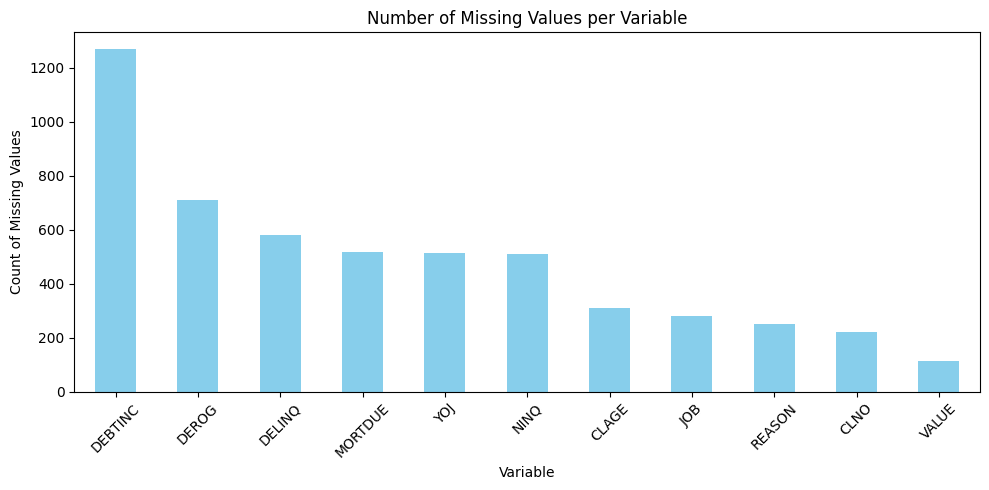

In [4]:
# Check the missing value from original dataset before doing any preprocessing

# Check the detail of each variable
total_missing = df.isna().sum()
print("Below is the detail of missing value for each variable:\n" + str(total_missing))

# Check the missing value proportion of each variable
total_proportion = df.isna().sum().sum() / (df.shape[0] * df.shape[1])*100
proportion = df.isna().sum()/len(df)*100
print("Proportion of Total Missing Value: " + str(total_proportion))
print("\nProportion of Missing Value for each variable: \n"+ str(proportion))

# Exclude columns with 0 missing
total_missing = total_missing[total_missing > 0]

# Plot as a bar chart for each variables
plt.figure(figsize=(10, 5))
total_missing.sort_values(ascending=False).plot(kind='bar', color='skyblue')

plt.title("Number of Missing Values per Variable")
plt.ylabel("Count of Missing Values")
plt.xlabel("Variable")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Drop the top 5% of rows with the most missing values across variables

In [5]:
df_filtered = df.copy()

# Add missing count column
df['missing_count'] = df.isnull().sum(axis=1)
df_filtered['missing_count'] = df_filtered.isnull().sum(axis=1)

# Calculate 95th percentile threshold
threshold = df_filtered['missing_count'].quantile(0.95)

# Keep rows below or equal to the threshold
df_filtered = df_filtered[df_filtered['missing_count'] <= threshold].copy()

# Check the detail and proportion after rows removal
total_missing = df_filtered.isna().sum()
print("Below is the detail of missing value for each variable:\n" + str(total_missing))

total_proportion = df_filtered.isna().sum().sum() / (df_filtered.shape[0] * df_filtered.shape[1])*100
proportion = df_filtered.isna().sum()/len(df_filtered)*100
print("Proportion of Total Missing Value: " + str(total_proportion))
print("\nProportion of Missing Value for each variable: \n"+ str(proportion))

# Count frequency of missing values per row
original_grouped = df['missing_count'].value_counts().sort_index()
filtered_grouped = df_filtered['missing_count'].value_counts().sort_index()

# Combine into one table
comparison_table = pd.DataFrame({
    'Missing_Variables': original_grouped.index,
    'Original_Count': original_grouped.values,
    'Filtered_Count': filtered_grouped.reindex(original_grouped.index, fill_value=0).values
})

# Add total row at the bottom
total_row = pd.DataFrame({
    'Missing_Variables': ['Total'],
    'Original_Count': [comparison_table['Original_Count'].sum()],
    'Filtered_Count': [comparison_table['Filtered_Count'].sum()]
})

comparison_table = pd.concat([comparison_table, total_row], ignore_index=True)

# Display the table
print(comparison_table)

# Identify removed rows
removed_rows = df[df['missing_count'] > threshold].copy()

# Compare shape
print("\nOriginal data:", df.shape)
print("Filtered data:", df_filtered.shape)
print("Removed rows:", removed_rows.shape)

# See where most missing occurs in removed rows
removed_missing_summary = removed_rows.isnull().sum().sort_values(ascending=False)
print("\nTop missing columns in removed rows:")
print(removed_missing_summary[removed_missing_summary > 0])

# Drop helper column
df_filtered.drop(columns='missing_count', inplace=True)

Below is the detail of missing value for each variable:
BAD                 0
LOAN                0
MORTDUE           385
VALUE              89
REASON            164
JOB               145
YOJ               352
DEROG             437
DELINQ            308
CLAGE              84
NINQ              240
CLNO                0
DEBTINC          1196
missing_count       0
dtype: int64
Proportion of Total Missing Value: 4.271893453951502

Proportion of Missing Value for each variable: 
BAD               0.000000
LOAN              0.000000
MORTDUE           6.772208
VALUE             1.565523
REASON            2.884785
JOB               2.550572
YOJ               6.191733
DEROG             7.686895
DELINQ            5.417766
CLAGE             1.477573
NINQ              4.221636
CLNO              0.000000
DEBTINC          21.037819
missing_count     0.000000
dtype: float64
   Missing_Variables  Original_Count  Filtered_Count
0                  0            3364            3364
1                  1  

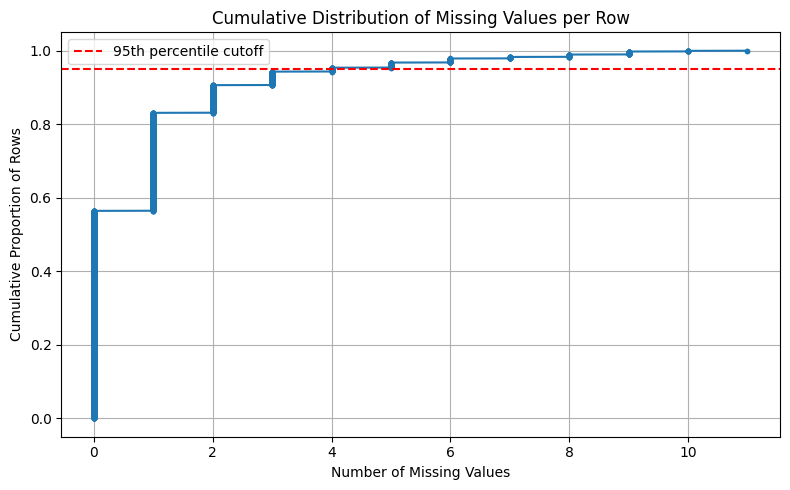

In [6]:
# Cumulative Distribution Visualization for 5% Removal

sorted_counts = np.sort(df['missing_count'])
cdf = np.arange(1, len(sorted_counts)+1) / len(sorted_counts)

plt.figure(figsize=(8, 5))
plt.plot(sorted_counts, cdf, marker='.')
plt.axhline(0.95, color='red', linestyle='--', label='95th percentile cutoff')
plt.title("Cumulative Distribution of Missing Values per Row")
plt.xlabel("Number of Missing Values")
plt.ylabel("Cumulative Proportion of Rows")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

MORTDUE: Missing = 20.00%, Not Missing = 19.89%, Diff = 0.11%
VALUE: Missing = 100.00%, Not Missing = 18.62%, Diff = 81.38%
YOJ: Missing = 15.06%, Not Missing = 20.21%, Diff = 5.16%
DEROG: Missing = 6.86%, Not Missing = 20.98%, Diff = 14.11%
DELINQ: Missing = 5.19%, Not Missing = 20.74%, Diff = 15.54%
CLAGE: Missing = 28.57%, Not Missing = 19.76%, Diff = 8.81%
NINQ: Missing = 8.75%, Not Missing = 20.39%, Diff = 11.64%
DEBTINC: Missing = 61.96%, Not Missing = 8.69%, Diff = 53.27%

Variables with default rate difference > 10%:
['VALUE', 'DEROG', 'DELINQ', 'NINQ', 'DEBTINC']


[05/08/25 18:24:30] WARNING  C:\Users\Ariq\AppData\Local\Temp\ipykernel_28576\3098430971.py:80:     ]8;id=70072;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=511928;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             UserWarning: set_ticklabels() should only be used with a fixed number                 
                             of ticks, i.e. after set_ticks() or using a FixedLocator.                             
                               ax.set_xticklabels(, ha='center')                                                   
                                                                                                                   

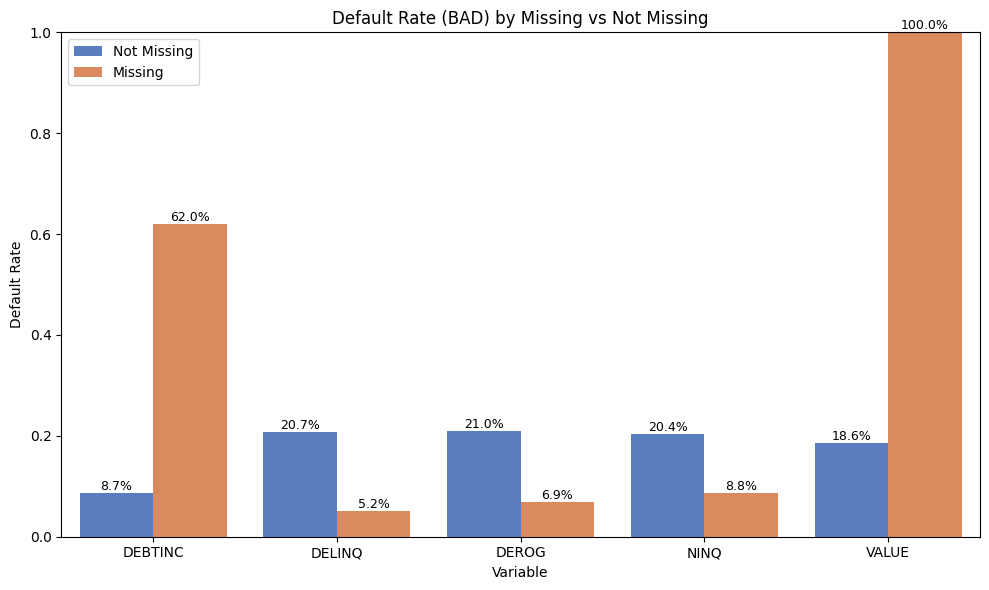

In [7]:
# Drop helper column
df.drop(columns='missing_count', inplace=True)

# List of variables to check
vars_to_check = ['MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

# Set the difference threshold (e.g., 10%)
threshold_diff = 0.10

# Store variables meeting the criteria
strong_difference_flags = []

# Analyze each variable
for var in vars_to_check:
    missing_df = df_filtered[df_filtered[var].isnull()]
    not_missing_df = df_filtered[df_filtered[var].notnull()]

    # Calculate default rates
    missing_default = missing_df['BAD'].mean() if not missing_df.empty else None
    not_missing_default = not_missing_df['BAD'].mean() if not missing_df.empty else None

    # Skip if one of the groups is empty
    if missing_default is None or not_missing_default is None:
        continue

    # Calculate difference
    diff = abs(missing_default - not_missing_default)

    print(f"{var}: Missing = {missing_default:.2%}, Not Missing = {not_missing_default:.2%}, Diff = {diff:.2%}")

    if diff > threshold_diff:
        strong_difference_flags.append(var)

print("\nVariables with default rate difference > {:.0%}:".format(threshold_diff))
print(strong_difference_flags)

# Create Flagging Column
for col in strong_difference_flags:
    df_filtered[f'{col}_missing'] = df_filtered[col].isnull().astype(int)

# List of missing flag columns
missing_flags = ['VALUE_missing', 'DEROG_missing', 'DELINQ_missing', 'NINQ_missing', 'DEBTINC_missing']


# Prepare long-form data for seaborn
df_plot = df_filtered[['BAD'] + missing_flags].copy()

df_melted = df_plot.melt(id_vars='BAD', value_vars=missing_flags,
                         var_name='Missing_Flag', value_name='Is_Missing')

# Group and calculate default rate for missing vs not missing
summary = df_melted.groupby(['Missing_Flag', 'Is_Missing'])['BAD'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=summary, x='Missing_Flag', y='BAD', hue='Is_Missing', palette='muted')

# Add % labels on top of bars
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v * 100:.1f}%' for v in container.datavalues], fontsize=9)

plt.title("Default Rate (BAD) by Missing vs Not Missing")
plt.ylabel("Default Rate")
plt.xlabel("Variable")

# Correct legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Not Missing', 'Missing'])

# Define a dictionary to rename
rename_dict = {
    'DEBTINC_missing': 'DEBTINC',
    'DELINQ_missing': 'DELINQ',
    'DEROG_missing': 'DEROG',
    'NINQ_missing': 'NINQ',
    'VALUE_missing': 'VALUE'
}

# Apply renaming after plotting
ax.set_xticklabels([rename_dict.get(label.get_text(), label.get_text()) for label in ax.get_xticklabels()], ha='center')

plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Building Assumptions: Change the Missing Value based on Assumptions made


In [8]:
# Missing Value in REASON means "Not Provided"
# Change Missing Value in Reason to Not Provided
df_filtered["REASON"] = df_filtered["REASON"].fillna("Not Provided")

# Missing Value in JOB categorized as "Not Provided"
# Change Missing Value in Job to Other
df_filtered["JOB"] = df_filtered["JOB"].fillna("Not Provided")

# Impute Missing Data in Columns MORTDUE, VALUE, YOJ, CLAGE, CLNO, DEBTINC with Median
cols_to_fill = ['MORTDUE', 'VALUE', 'YOJ', 'CLAGE', 'CLNO', 'DEBTINC']

for col in cols_to_fill:
    df_filtered[col] = df_filtered[col].fillna(df_filtered[col].median())

#Impute Missing Data in Columns DEROG, DELINQ, NINQ with Zero
cols_to_fill = ['DEROG', 'DELINQ', 'NINQ']

for col in cols_to_fill:
    df_filtered[col] = df_filtered[col].fillna(0)

## Outlier Handling

In [9]:
# Vars where only the upper end should be capped
upper_only = ['DEROG', 'DELINQ', 'NINQ']

# Vars where both ends can be capped
both_ends = ['CLNO', 'DEBTINC']

# Apply upper-only capping
for var in upper_only:
    upper = df_filtered[var].quantile(0.995)
    df_filtered[var] = np.where(df_filtered[var] > upper, upper, df_filtered[var])

# Apply full windsorizing for others
for var in both_ends:
    lower = df_filtered[var].quantile(0.005)
    upper = df_filtered[var].quantile(0.995)
    df_filtered[var] = np.clip(df_filtered[var], lower, upper)

# Apply upper cap removal for CLAGE
upper_limit = df_filtered['CLAGE'].quantile(0.99975)

# Remove rows with outliers
df_filtered = df_filtered[df_filtered['CLAGE'] <= upper_limit]

# Apply one-hot encoding to Categorical columns
df_encoded = pd.get_dummies(df_filtered, columns=['REASON', 'JOB'], prefix=['REASON', 'JOB'],dtype=int)

# Display the encoded DataFrame
df_encoded.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,REASON_DebtCon,REASON_HomeImp,REASON_Not Provided,JOB_Mgr,JOB_Not Provided,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.0,0.0,94.366667,1.0,9.0,...,0,1,0,0,0,0,1,0,0,0
1,1,1300,70053.0,68400.0,7.0,0.0,2.0,121.833333,0.0,14.0,...,0,1,0,0,0,0,1,0,0,0
2,1,1500,13500.0,16700.0,4.0,0.0,0.0,149.466667,1.0,10.0,...,0,1,0,0,0,0,1,0,0,0
4,0,1700,97800.0,112000.0,3.0,0.0,0.0,93.333333,0.0,14.0,...,0,1,0,0,0,1,0,0,0,0
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,...,0,1,0,0,0,0,1,0,0,0


## Skewness Handling

In [10]:
# Log Transform Data

# Select numeric columns
numeric_cols = df_encoded.select_dtypes(include=[np.number])

# Exclude binary columns (only two unique values: 0 and 1)
non_binary_numeric_cols = [
    col for col in numeric_cols.columns
    if not set(df_encoded[col].dropna().unique()).issubset({0, 1})
]

# Check skewness on non-binary numeric columns
skewed_cols = df_encoded[non_binary_numeric_cols].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_cols = skewed_cols[skewed_cols > 1].index.tolist()  # Adjust threshold if needed

# Apply log1p to skewed columns only
df_final_log = df_encoded.copy()
df_final_log[skewed_cols] = df_final_log[skewed_cols].apply(np.log1p)

df_final_log

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,REASON_DebtCon,REASON_HomeImp,REASON_Not Provided,JOB_Mgr,JOB_Not Provided,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,7.003974,10.160491,10.571983,2.442347,0.0,0.000000,94.366667,0.693147,9.0,...,0,1,0,0,0,0,1,0,0,0
1,1,7.170888,11.157022,11.133143,2.079442,0.0,1.098612,121.833333,0.000000,14.0,...,0,1,0,0,0,0,1,0,0,0
2,1,7.313887,9.510519,9.723224,1.609438,0.0,0.000000,149.466667,0.693147,10.0,...,0,1,0,0,0,0,1,0,0,0
4,0,7.438972,11.490690,11.626263,1.386294,0.0,0.000000,93.333333,0.000000,14.0,...,0,1,0,0,0,1,0,0,0,0
5,1,7.438972,10.327087,10.604628,2.302585,0.0,0.000000,101.466002,0.693147,8.0,...,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,11.395279,10.955445,11.409629,2.833213,0.0,0.000000,221.808718,0.000000,16.0,...,1,0,0,0,0,0,1,0,0,0
5956,0,11.396403,10.907368,11.439688,2.833213,0.0,0.000000,208.692070,0.000000,15.0,...,1,0,0,0,0,0,1,0,0,0
5957,0,11.398648,10.897591,11.439548,2.772589,0.0,0.000000,212.279697,0.000000,15.0,...,1,0,0,0,0,0,1,0,0,0
5958,0,11.405351,10.827171,11.428043,2.708050,0.0,0.000000,213.892709,0.000000,16.0,...,1,0,0,0,0,0,1,0,0,0


In [11]:
# Result of Log Transform

# Checj all the numerical columns
numeric_cols = df_encoded.select_dtypes(include=[np.number])

# Calculate original skewness
original_skew = numeric_cols.apply(lambda x: x.skew())

# Identify binary columns (with only 0 and 1)
is_binary = numeric_cols.apply(lambda x: set(x.dropna().unique()).issubset({0, 1}))

# Identify skewed columns (abs(skew) > 1) and not binary
skewed_cols = original_skew[(original_skew.abs() > 1) & (~is_binary)].index.tolist()

# Apply log1p to those skewed columns only
df_transformed = df_encoded.copy()
df_transformed[skewed_cols] = df_transformed[skewed_cols].apply(np.log1p)

# Calculate skewness after log transform
log_skew = df_transformed[skewed_cols].apply(lambda x: x.skew())

# Combine into a comparison table
skew_comparison = pd.DataFrame({
    'Original Skewness': original_skew[skewed_cols],
    'Log-Transformed Skewness': log_skew
})

print(skew_comparison)

         Original Skewness  Log-Transformed Skewness
LOAN              2.018245                 -0.298269
MORTDUE           1.913507                 -0.877811
VALUE             3.095928                 -0.081556
YOJ               1.055312                 -0.581259
DEROG             4.710094                  3.032010
DELINQ            3.216216                  2.082129
NINQ              2.456558                  0.783501


## Data Scaling and Partition

In [12]:
# Identify numerical columns
numerical_columns = df_final_log.select_dtypes(include=['number']).columns.tolist()

# Identify binary columns (only contain 0 and 1)
binary_columns = [col for col in numerical_columns if set(df_final_log[col].unique()).issubset({0, 1})]

# Identify non-binary numerical columns
non_binary_numerical_columns = [col for col in numerical_columns if col not in binary_columns and col != 'BAD']

# Standard scale only the non-binary numerical columns
scaler = StandardScaler()
df_final_log[non_binary_numerical_columns] = scaler.fit_transform(df_final_log[non_binary_numerical_columns])

# Drop target column and separate X, y
X = df_final_log.drop(columns='BAD')
y = df_final_log['BAD']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_scaled_df = pd.DataFrame(X_train, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test, columns=X.columns)

## Feature Selection

In [13]:
# Forward Feature Selection using Logistic Regression
logreg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=10000)

sfs = SequentialFeatureSelector(
    logreg,
    direction='forward',
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

sfs.fit(X_train_scaled_df, y_train)

# Get selected feature names
selected_features = X_train_scaled_df.columns[sfs.get_support()]
print("Selected features for all models:")
print(list(selected_features))

# Keep only selected features in scaled datasets
X_train = X_train_scaled_df[selected_features]
X_test = X_test_scaled_df[selected_features]

Selected features for all models:
['LOAN', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'VALUE_missing', 'DEROG_missing', 'DEBTINC_missing', 'JOB_Office', 'JOB_Sales']


# Model Building

## Logistic Regression

### Base Model

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3484  159]
 [ 341  562]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.93      3643
           1       0.78      0.62      0.69       903

    accuracy                           0.89      4546
   macro avg       0.85      0.79      0.81      4546
weighted avg       0.88      0.89      0.89      4546

Train ROC AUC: 0.9097

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[864  47]
 [ 88 138]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       911
           1       0.75      0.61      0.67       226

    accuracy                           0.88      1137
   macro avg       0.83      0.78      0.80      1137
weighted avg       0.88      0.88      0.88      1137

Test ROC AUC: 0.8959


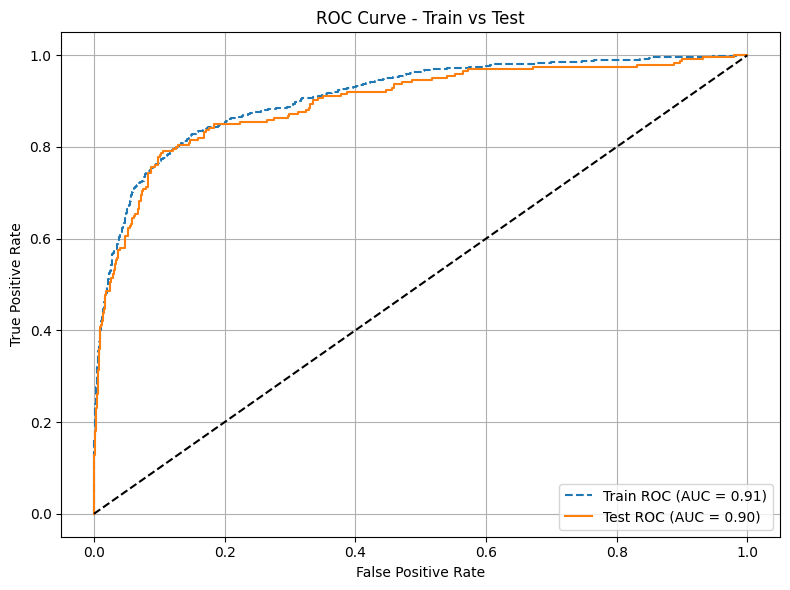

In [14]:
# Train the model
model_logistic = LogisticRegression(solver='liblinear', max_iter=10000, random_state=42)
model_logistic.fit(X_train, y_train)

# Predict for both train and test sets
y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

y_train_proba = model_logistic.predict_proba(X_train)[:, 1]
y_test_proba = model_logistic.predict_proba(X_test)[:, 1]

# ROC AUC for both
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# Print results
print("===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {auc_train:.4f}")

print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {auc_test:.4f}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Train vs Test")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hyperparameter Tuning

Fitting 10 folds for each of 16 candidates, totalling 160 fits

Best Parameters Found: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3033  610]
 [ 174  729]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89      3643
           1       0.54      0.81      0.65       903

    accuracy                           0.83      4546
   macro avg       0.75      0.82      0.77      4546
weighted avg       0.87      0.83      0.84      4546

Train ROC AUC: 0.8984

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[760 151]
 [ 43 183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.83      0.89       911
           1       0.55      0.81      0.65       226

    accuracy                           0.83      1137
   macro avg       0.75      0.82      0.77      1137
weig

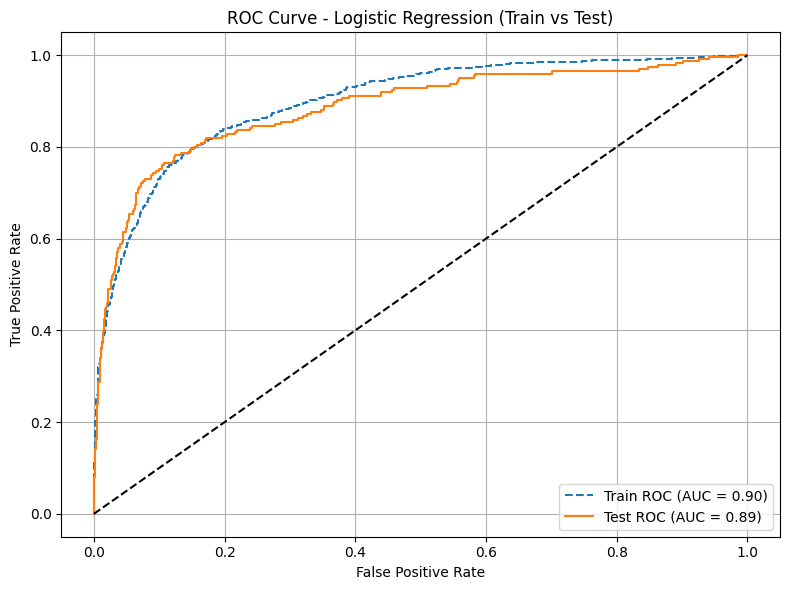

True Negatives (TN): 760
False Positives (FP): 151
False Negatives (FN): 43
True Positives (TP): 183
Expected Profit Logistic Regression: 566


[05/08/25 18:25:36] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=464762;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=36718;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.03326560590934437

EMPC Fraction:  0.08706304807935693


In [15]:
# Set up hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

# Grid search with cross-validation
logreg_base = LogisticRegression(max_iter=10000, random_state=42)
grid_search = GridSearchCV(
    estimator=logreg_base,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_logreg = grid_search.best_estimator_

print("\nBest Parameters Found:", grid_search.best_params_)

# Predict for both train and test sets
y_train_pred = best_logreg.predict(X_train)
y_test_pred = best_logreg.predict(X_test)

y_train_proba = best_logreg.predict_proba(X_train)[:, 1]
y_test_proba = best_logreg.predict_proba(X_test)[:, 1]

# ROC AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# Print results
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {auc_train:.4f}")

print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {auc_test:.4f}")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Expected Profit
TN_logistic, FP_logistic, FN_logistic, TP_logistic = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_logistic}")
print(f"False Positives (FP): {FP_logistic}")
print(f"False Negatives (FN): {FN_logistic}")
print(f"True Positives (TP): {TP_logistic}")
exp_profit_logistic=TN_logistic-FN_logistic-FP_logistic
print(f"Expected Profit Logistic Regression: {exp_profit_logistic}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

### Hyperparameter Tuning + SMOTE

Fitting 5 folds for each of 8 candidates, totalling 40 fits

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3055  588]
 [ 169  734]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89      3643
           1       0.56      0.81      0.66       903

    accuracy                           0.83      4546
   macro avg       0.75      0.83      0.77      4546
weighted avg       0.87      0.83      0.84      4546

Train ROC AUC: 0.8987

===== TEST SET EVALUATION =====
Best Parameters: {'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Confusion Matrix:
 [[763 148]
 [ 44 182]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89       911
           1       0.55      0.81      0.65       226

    accuracy                           0.83      1137
   macro avg       0.75      0.82      0.77      1137
weig

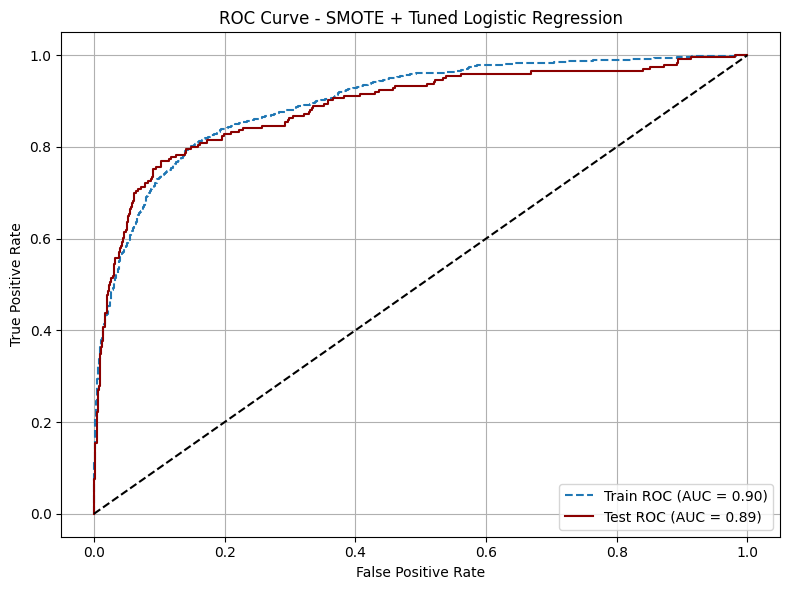

True Negatives (TN): 763
False Positives (FP): 148
False Negatives (FN): 44
True Positives (TP): 182
Expected Profit Logistic Regression: 571


[05/08/25 18:25:41] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=70092;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=680349;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.033637325365037246

EMPC Fraction:  0.08838523742013343

Class Distribution After SMOTE:
BAD
0    3643
1    3643
Name: count, dtype: int64


In [16]:
# Define pipeline
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(solver='liblinear', max_iter=10000, random_state=42))
])

# Define hyperparameter grid
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None]
}

# Grid search
grid_smote = GridSearchCV(
    smote_pipeline,
    param_grid=param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_smote.fit(X_train, y_train)
best_smote_model = grid_smote.best_estimator_

# Predictions
y_train_pred = best_smote_model.predict(X_train)
y_test_pred = best_smote_model.predict(X_test)

y_train_proba = best_smote_model.predict_proba(X_train)[:, 1]
y_test_proba = best_smote_model.predict_proba(X_test)[:, 1]

# Evaluation — TRAIN SET
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# Evaluation — TEST SET
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_smote.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# ROC Curve (Train vs Test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_proba):.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='darkred')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SMOTE + Tuned Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Expected Profit
TN_logistic, FP_logistic, FN_logistic, TP_logistic = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_logistic}")
print(f"False Positives (FP): {FP_logistic}")
print(f"False Negatives (FN): {FN_logistic}")
print(f"True Positives (TP): {TP_logistic}")
exp_profit_logistic=TN_logistic-FN_logistic-FP_logistic
print(f"Expected Profit Logistic Regression: {exp_profit_logistic}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

# Class balance after SMOTE
X_res, y_res = best_smote_model.named_steps['smote'].fit_resample(X_train, y_train)
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_res).value_counts())

### Hyperparameter Tuning + RUS

Fitting 5 folds for each of 8 candidates, totalling 40 fits

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[2835  808]
 [ 153  750]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.86      3643
           1       0.48      0.83      0.61       903

    accuracy                           0.79      4546
   macro avg       0.72      0.80      0.73      4546
weighted avg       0.86      0.79      0.81      4546

Train ROC AUC: 0.8867

===== TEST SET EVALUATION =====
Best Parameters: {'lr__C': 0.01, 'lr__class_weight': None, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Confusion Matrix:
 [[707 204]
 [ 41 185]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.78      0.85       911
           1       0.48      0.82      0.60       226

    accuracy                           0.78      1137
   macro avg       0.71      0.80      0.73      1137
weig

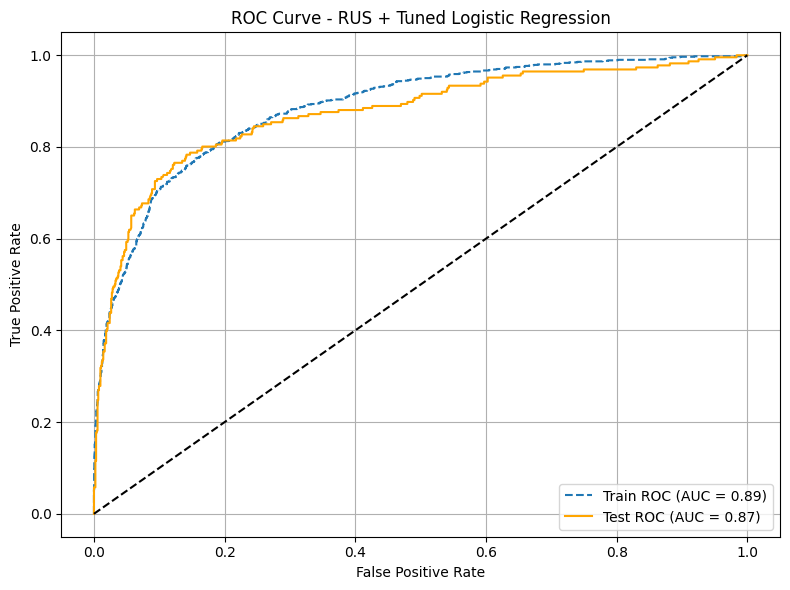

True Negatives (TN): 707
False Positives (FP): 204
False Negatives (FN): 41
True Positives (TP): 185
Expected Profit Logistic Regression: 462


[05/08/25 18:25:44] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=898034;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=778956;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.031985307493283585

EMPC Fraction:  0.0895900851441511

Class Distribution After RUS:
BAD
0    903
1    903
Name: count, dtype: int64


In [17]:
# 1. Define pipeline
rus_pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('lr', LogisticRegression(solver='liblinear', max_iter=10000, random_state=42))
])

# 2. Use same param grid as SMOTE
param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.01, 0.1, 1, 10],
    'lr__solver': ['liblinear'],
    'lr__class_weight': [None]
}

# 3. GridSearchCV
grid_rus = GridSearchCV(
    rus_pipeline,
    param_grid,
    scoring='recall',  # or 'roc_auc'
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 4. Fit model
grid_rus.fit(X_train, y_train)
best_rus_model = grid_rus.best_estimator_

# 5. Predictions
y_train_pred = best_rus_model.predict(X_train)
y_test_pred = best_rus_model.predict(X_test)

y_train_proba = best_rus_model.predict_proba(X_train)[:, 1]
y_test_proba = best_rus_model.predict_proba(X_test)[:, 1]

# 6. Evaluation — TRAIN SET
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# 7. Evaluation — TEST SET
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_rus.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 8. ROC Curve — Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_proba):.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RUS + Tuned Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Expected Profit
TN_logistic, FP_logistic, FN_logistic, TP_logistic = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_logistic}")
print(f"False Positives (FP): {FP_logistic}")
print(f"False Negatives (FN): {FN_logistic}")
print(f"True Positives (TP): {TP_logistic}")
exp_profit_logistic=TN_logistic-FN_logistic-FP_logistic
print(f"Expected Profit Logistic Regression: {exp_profit_logistic}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

# 10. Class distribution check after RUS
X_res, y_res = best_rus_model.named_steps['rus'].fit_resample(X_train, y_train)
print("\nClass Distribution After RUS:")
print(pd.Series(y_res).value_counts())

## Decision Tree

### Base Model

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3643    0]
 [   0  903]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3643
           1       1.00      1.00      1.00       903

    accuracy                           1.00      4546
   macro avg       1.00      1.00      1.00      4546
weighted avg       1.00      1.00      1.00      4546

Train ROC AUC Score: 1.0000

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[839  72]
 [ 75 151]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       911
           1       0.68      0.67      0.67       226

    accuracy                           0.87      1137
   macro avg       0.80      0.79      0.80      1137
weighted avg       0.87      0.87      0.87      1137

Test ROC AUC Score: 0.7946


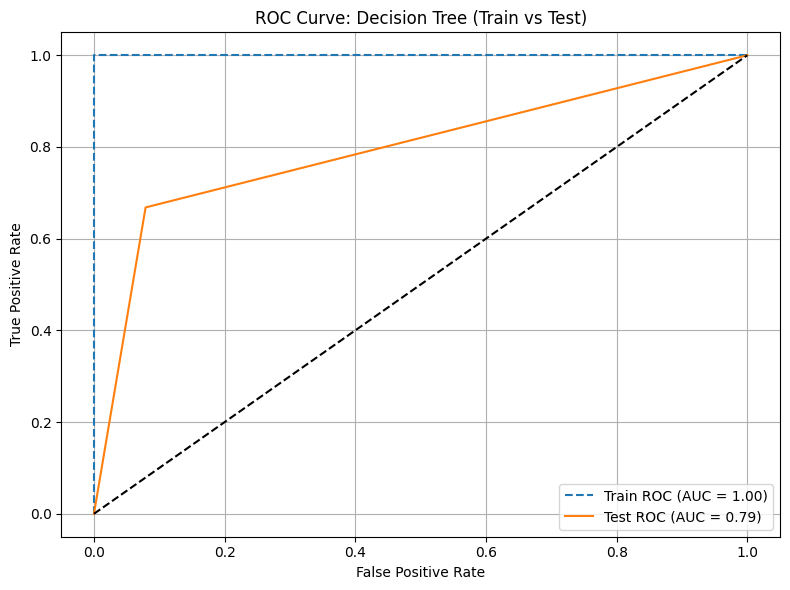

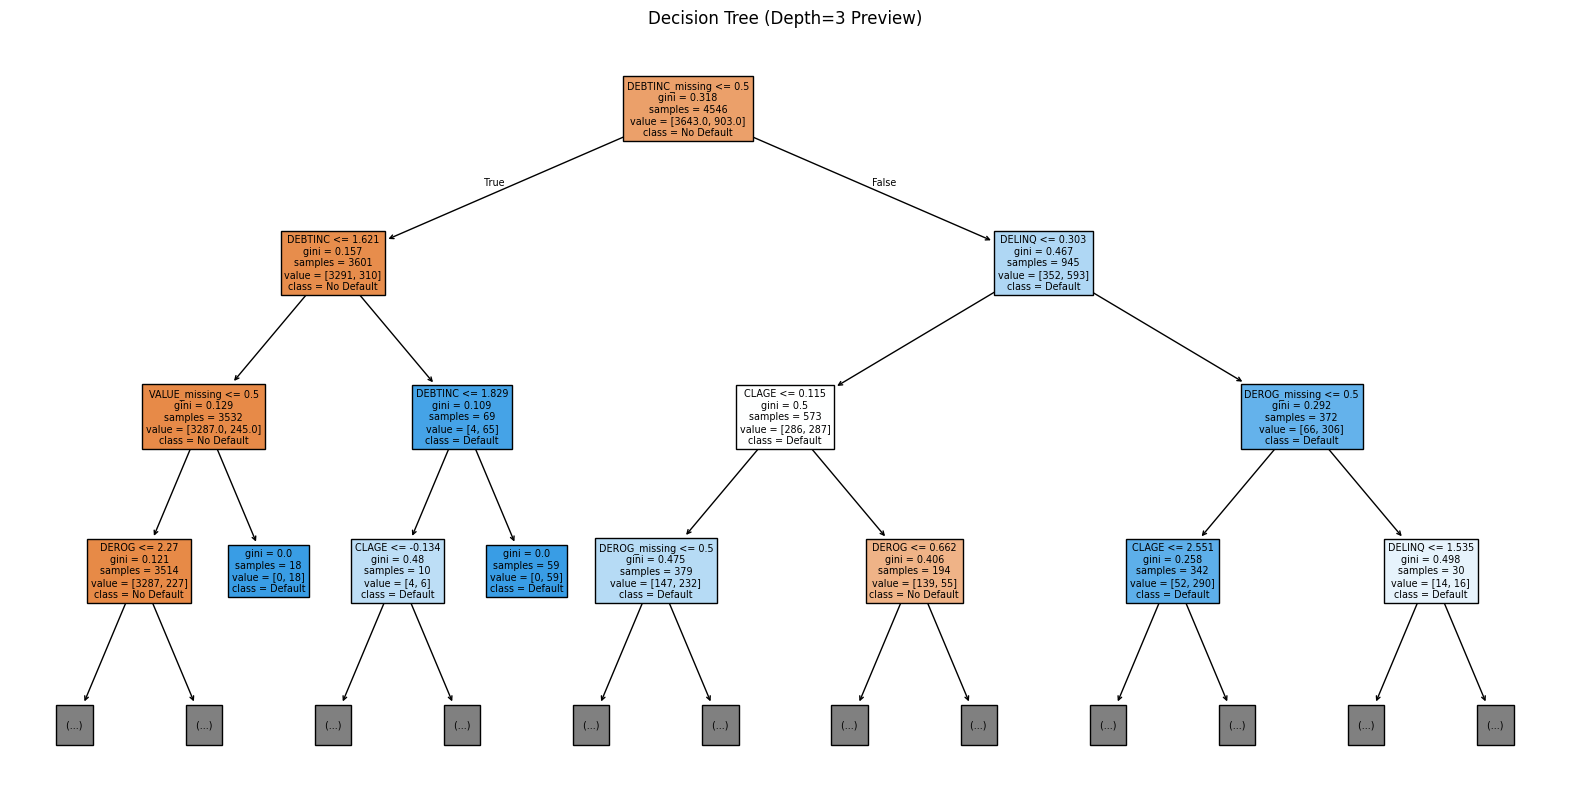

In [18]:
# 1. Train the Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# 2. Predictions
y_train_pred_dt = dt_model.predict(X_train)
y_test_pred_dt = dt_model.predict(X_test)

y_train_proba_dt = dt_model.predict_proba(X_train)[:, 1]
y_test_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# 3. AUC scores
auc_train = roc_auc_score(y_train, y_train_proba_dt)
auc_test = roc_auc_score(y_test, y_test_proba_dt)

# 4. Evaluation: Train
print("===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_dt))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_dt))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 5. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_dt))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 6. ROC Curve: Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_dt)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Decision Tree (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Visualize the Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, feature_names=X_train.columns, class_names=['No Default', 'Default'], max_depth=3)
plt.title("Decision Tree (Depth=3 Preview)")
plt.show()

### Hyperparameter Tuning

Fitting 10 folds for each of 432 candidates, totalling 4320 fits

Best Parameters Found: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[1559 2084]
 [  71  832]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.43      0.59      3643
           1       0.29      0.92      0.44       903

    accuracy                           0.53      4546
   macro avg       0.62      0.67      0.51      4546
weighted avg       0.82      0.53      0.56      4546

Train ROC AUC Score: 0.7490

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[369 542]
 [ 20 206]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.41      0.57       911
           1       0.28      0.91      0.42       226

    accuracy                           0.51    

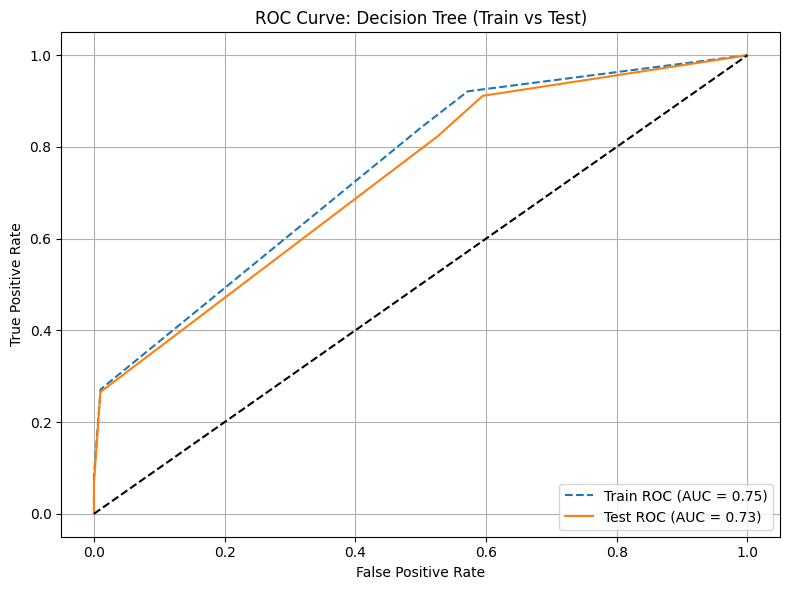

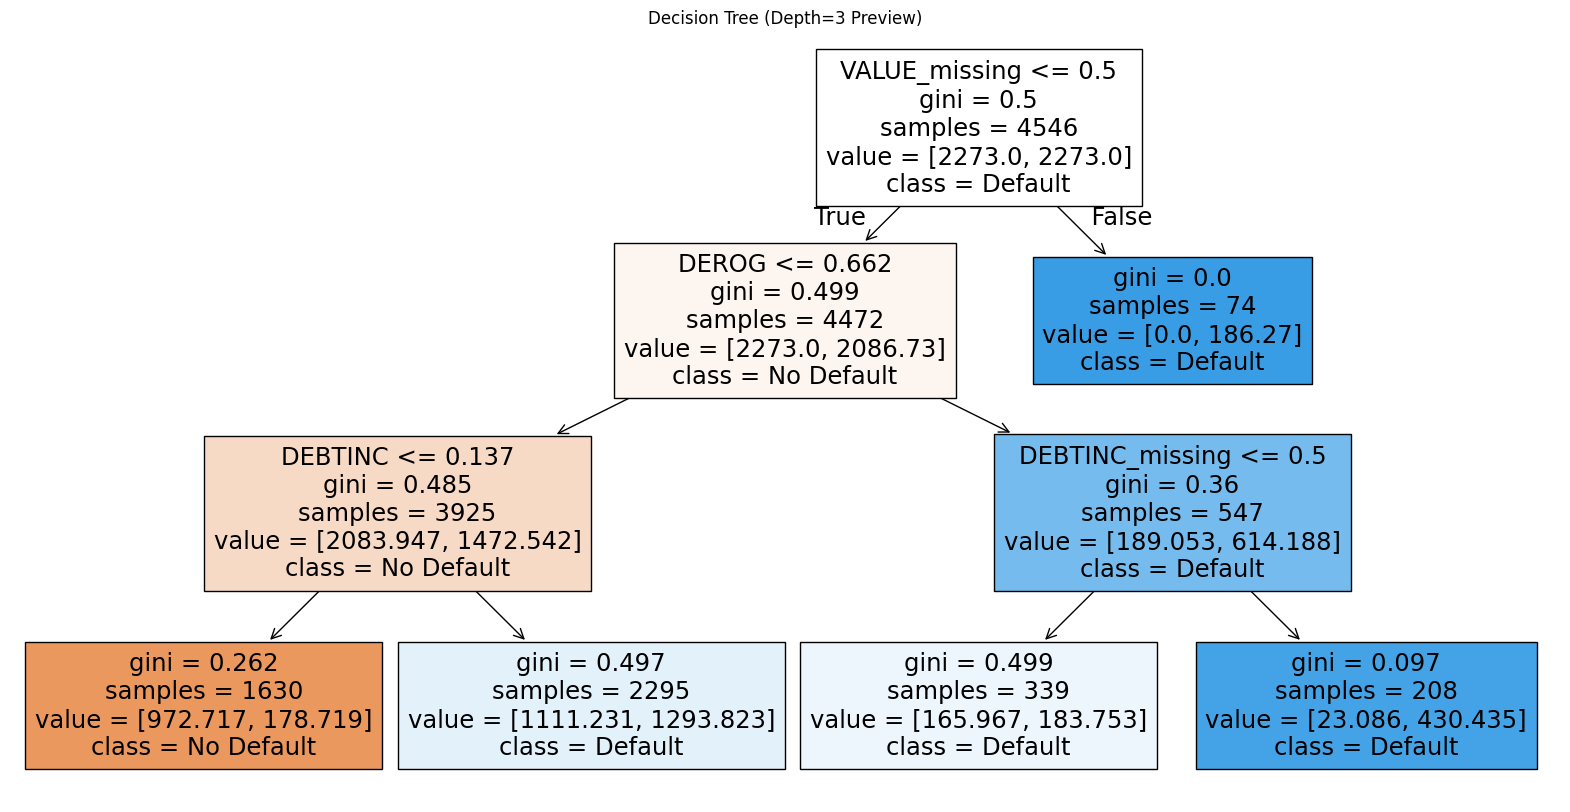

True Negatives (TN): 369
False Positives (FP): 542
False Negatives (FN): 20
True Positives (TP): 206
Expected Profit Decision Tree: -193
******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.014062928631091189

EMPC Fraction:  0.09341338747725926


In [19]:
# 1. Define hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'class_weight': [None,'balanced']
}

# 2. Set up GridSearchCV
dt_base = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt_base,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_dt_model = grid_search.best_estimator_

print("\nBest Parameters Found:", grid_search.best_params_)

# 3. Predictions
y_train_pred_dt = best_dt_model.predict(X_train)
y_test_pred_dt = best_dt_model.predict(X_test)

y_train_proba_dt = best_dt_model.predict_proba(X_train)[:, 1]
y_test_proba_dt = best_dt_model.predict_proba(X_test)[:, 1]

# 4. AUC scores
auc_train = roc_auc_score(y_train, y_train_proba_dt)
auc_test = roc_auc_score(y_test, y_test_proba_dt)

# 5. Evaluation: Train
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_dt))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_dt))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 6. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_dt))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 7. ROC Curve: Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_dt)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_dt)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Decision Tree (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Visualize the best tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model,
    filled=True,
    feature_names=X_train.columns,
    class_names=['No Default', 'Default'],
    max_depth=3
)
plt.title("Decision Tree (Depth=3 Preview)")
plt.show()

# 9. Expected Profit
TN_dt, FP_dt, FN_dt, TP_dt = confusion_matrix(y_test, y_test_pred_dt).ravel()
print(f"True Negatives (TN): {TN_dt}")
print(f"False Positives (FP): {FP_dt}")
print(f"False Negatives (FN): {FN_dt}")
print(f"True Positives (TP): {TP_dt}")
exp_profit_dt=TN_dt-FN_dt-FP_dt
print(f"Expected Profit Decision Tree: {exp_profit_dt}")
emp_result = empCreditScoring(y_test_proba_dt, y_test, print_output=True)

### Hyperparameter Tuning + SMOTE

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[2867  776]
 [ 173  730]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.79      0.86      3643
           1       0.48      0.81      0.61       903

    accuracy                           0.79      4546
   macro avg       0.71      0.80      0.73      4546
weighted avg       0.85      0.79      0.81      4546

Train ROC AUC: 0.8678

===== TEST SET EVALUATION =====
Best Parameters: {'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Confusion Matrix:
 [[692 219]
 [ 53 173]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.76      0.84       911
           1       0.44      0.77      0.56       226

    accuracy                           0.76

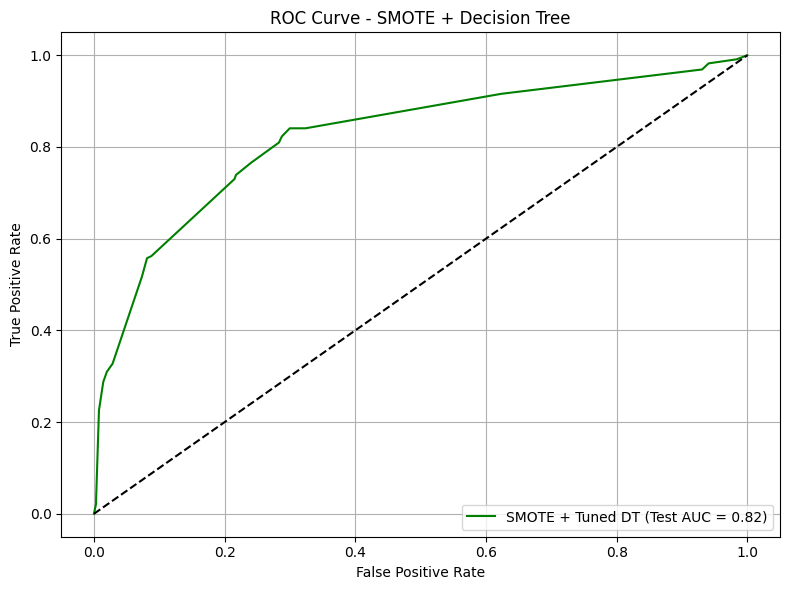


Class Distribution After SMOTE:
BAD
0    3643
1    3643
Name: count, dtype: int64
True Negatives (TN): 692
False Positives (FP): 219
False Negatives (FN): 53
True Positives (TP): 173
Expected Profit Decision Tree: 420
******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.02474745938295527

EMPC Fraction:  0.10534559958579226


In [20]:
# 1. Define pipeline
smote_dt_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# 2. Define hyperparameter grid
param_grid_dt = {
    'dt__max_depth': [3, 5, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 3, 5],
    'dt__max_features': [None, 'sqrt', 'log2'],
    'dt__criterion': ['gini', 'entropy'],
    'dt__class_weight': [None]
}

# 3. Grid search
grid_smote_dt = GridSearchCV(
    smote_dt_pipeline,
    param_grid=param_grid_dt,
    scoring='recall',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 4. Fit model
grid_smote_dt.fit(X_train, y_train)
best_dt_smote = grid_smote_dt.best_estimator_

# 5. Predictions
y_train_pred = best_dt_smote.predict(X_train)
y_test_pred = best_dt_smote.predict(X_test)

y_train_proba = best_dt_smote.predict_proba(X_train)[:, 1]
y_test_proba = best_dt_smote.predict_proba(X_test)[:, 1]

# 6. Evaluation — TRAINING SET
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# 7. Evaluation — TEST SET
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_smote_dt.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 8. ROC Curve — Test Set
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'SMOTE + Tuned DT (Test AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SMOTE + Decision Tree")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Class balance check after SMOTE
X_res, y_res = best_dt_smote.named_steps['smote'].fit_resample(X_train, y_train)
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_res).value_counts())

# 10. Expected Profit
TN_dt, FP_dt, FN_dt, TP_dt = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_dt}")
print(f"False Positives (FP): {FP_dt}")
print(f"False Negatives (FN): {FN_dt}")
print(f"True Positives (TP): {TP_dt}")
exp_profit_dt=TN_dt-FN_dt-FP_dt
print(f"Expected Profit Decision Tree: {exp_profit_dt}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

### Hyperparameter Tuning + RUS

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[1547 2096]
 [  70  833]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.42      0.59      3643
           1       0.28      0.92      0.43       903

    accuracy                           0.52      4546
   macro avg       0.62      0.67      0.51      4546
weighted avg       0.82      0.52      0.56      4546

Train ROC AUC: 0.7464

===== TEST SET EVALUATION =====
Best Parameters: {'dt__class_weight': None, 'dt__criterion': 'entropy', 'dt__max_depth': 3, 'dt__max_features': 'sqrt', 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Confusion Matrix:
 [[369 542]
 [ 20 206]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.41      0.57       911
           1       0.28      0.91      0.42       226

    accuracy                           0

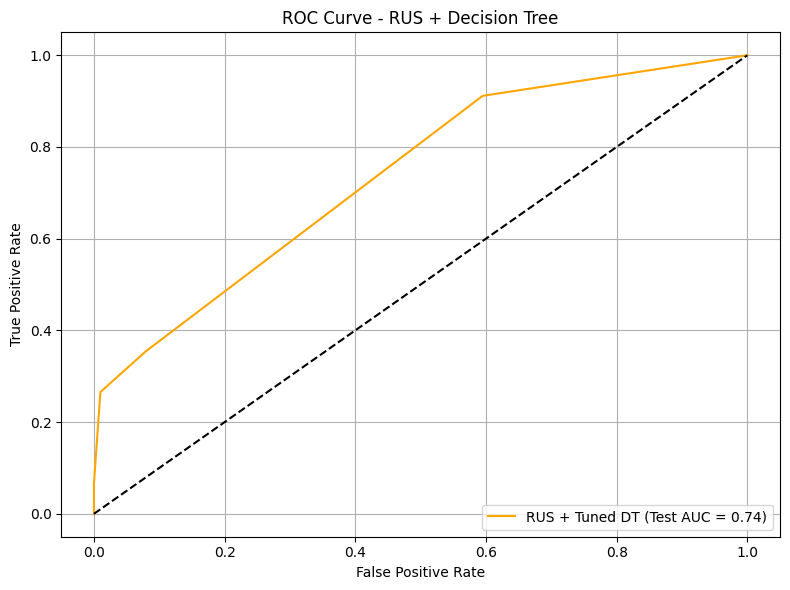


Class Distribution After RUS:
BAD
0    903
1    903
Name: count, dtype: int64
True Negatives (TN): 369
False Positives (FP): 542
False Negatives (FN): 20
True Positives (TP): 206
Expected Profit Decision Tree: -193
******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.01412543752789993

EMPC Fraction:  0.09294055164663341


In [21]:
# 1. Define pipeline
rus_dt_pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# 2. Grid search
grid_rus_dt = GridSearchCV(
    rus_dt_pipeline,
    param_grid=param_grid_dt,
    scoring='recall',  # or 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 3. Fit model
grid_rus_dt.fit(X_train, y_train)
best_dt_rus = grid_rus_dt.best_estimator_

# 4. Predictions
y_train_pred = best_dt_rus.predict(X_train)
y_test_pred = best_dt_rus.predict(X_test)

y_train_proba = best_dt_rus.predict_proba(X_train)[:, 1]
y_test_proba = best_dt_rus.predict_proba(X_test)[:, 1]

# 5. Evaluation — TRAINING SET
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# 6. Evaluation — TEST SET
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_rus_dt.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 7. ROC Curve — Test Set
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RUS + Tuned DT (Test AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RUS + Decision Tree")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Class balance check after RUS
X_res, y_res = best_dt_rus.named_steps['rus'].fit_resample(X_train, y_train)
print("\nClass Distribution After RUS:")
print(pd.Series(y_res).value_counts())

# 9. Expected Profit
TN_dt, FP_dt, FN_dt, TP_dt = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_dt}")
print(f"False Positives (FP): {FP_dt}")
print(f"False Negatives (FN): {FN_dt}")
print(f"True Positives (TP): {TP_dt}")
exp_profit_dt=TN_dt-FN_dt-FP_dt
print(f"Expected Profit Decision Tree: {exp_profit_dt}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

## Random Forrest

### Base Model


===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3643    0]
 [   0  903]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3643
           1       1.00      1.00      1.00       903

    accuracy                           1.00      4546
   macro avg       1.00      1.00      1.00      4546
weighted avg       1.00      1.00      1.00      4546

Train ROC AUC Score: 1.0000

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[875  36]
 [ 65 161]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       911
           1       0.82      0.71      0.76       226

    accuracy                           0.91      1137
   macro avg       0.87      0.84      0.85      1137
weighted avg       0.91      0.91      0.91      1137

Test ROC AUC Score: 0.9310


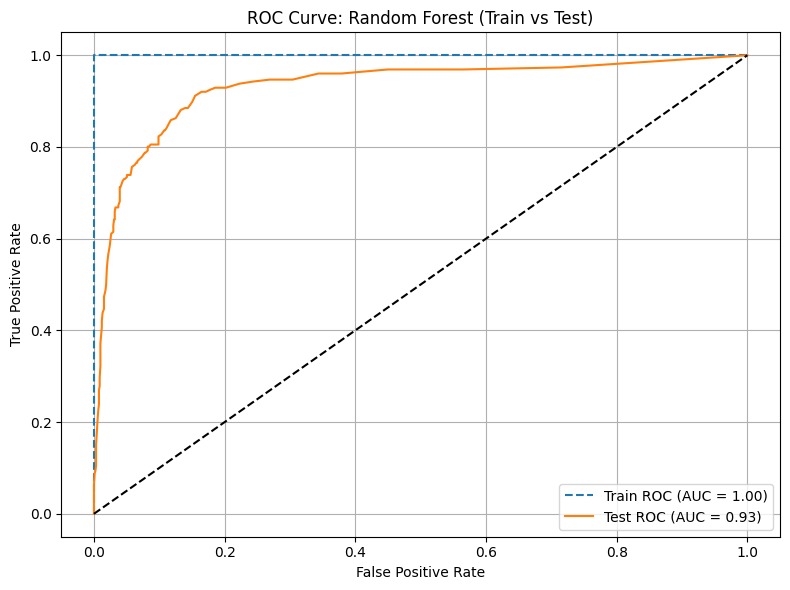

In [22]:
# 1. Initialize and train the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# 2. Predictions: train and test
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

y_train_proba_rf = rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. AUC Scores
auc_train_rf = roc_auc_score(y_train, y_train_proba_rf)
auc_test_rf = roc_auc_score(y_test, y_test_proba_rf)

# 4. Train Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_rf))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_rf))
print(f"Train ROC AUC Score: {auc_train_rf:.4f}")

# 5. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_rf))
print(f"Test ROC AUC Score: {auc_test_rf:.4f}")

# 6. ROC Curve: Train vs Test
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_proba_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f"Train ROC (AUC = {auc_train_rf:.2f})", linestyle='--')
plt.plot(fpr_test_rf, tpr_test_rf, label=f"Test ROC (AUC = {auc_test_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Random Forest (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [ ]:
# Define param grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 1500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

# Set up the grid search
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# 3. Predictions
y_train_pred_rf = best_rf_model.predict(X_train)
y_test_pred_rf = best_rf_model.predict(X_test)

y_train_proba_rf = best_rf_model.predict_proba(X_train)[:, 1]
y_test_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

# 4. AUC Scores
auc_train_rf = roc_auc_score(y_train, y_train_proba_rf)
auc_test_rf = roc_auc_score(y_test, y_test_proba_rf)

# 5. Train Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_rf))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_rf))
print(f"Train ROC AUC Score: {auc_train_rf:.4f}")

# 6. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_rf))
print(f"Test ROC AUC Score: {auc_test_rf:.4f}")

# 7. ROC Curve: Train vs Test
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_proba_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_proba_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train_rf, tpr_train_rf, label=f"Train ROC (AUC = {auc_train_rf:.2f})", linestyle='--')
plt.plot(fpr_test_rf, tpr_test_rf, label=f"Test ROC (AUC = {auc_test_rf:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Random Forest (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Expected Profit
TN_rf, FP_rf, FN_rf, TP_rf = confusion_matrix(y_test, y_test_pred_rf).ravel()
print(f"True Negatives (TN): {TN_rf}")
print(f"False Positives (FP): {FP_rf}")
print(f"False Negatives (FN): {FN_rf}")
print(f"True Positives (TP): {TP_rf}")
exp_profit_rf=TN_rf-FN_rf-FP_rf
print(f"Expected Profit Random Forest: {exp_profit_rf}")
emp_result = empCreditScoring(y_test_proba_rf, y_test, print_output=True)

## XGBoost

### Base Model

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3582   61]
 [   0  903]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3643
           1       0.94      1.00      0.97       903

    accuracy                           0.99      4546
   macro avg       0.97      0.99      0.98      4546
weighted avg       0.99      0.99      0.99      4546

Train ROC AUC Score: 0.9997

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[840  71]
 [ 48 178]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       911
           1       0.71      0.79      0.75       226

    accuracy                           0.90      1137
   macro avg       0.83      0.85      0.84      1137
weighted avg       0.90      0.90      0.90      1137

Test ROC AUC Score: 0.9299


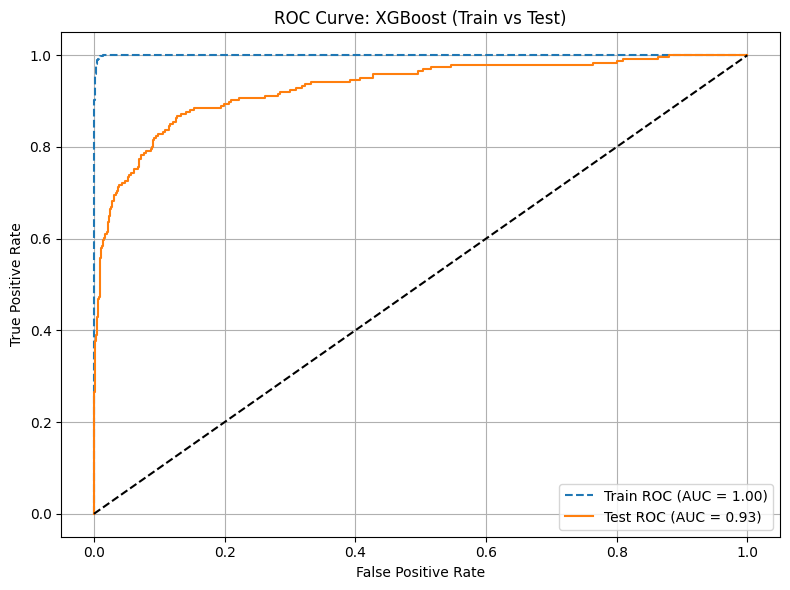

In [23]:
# 1. Train the model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42,
)

xgb_model.fit(X_train, y_train)

# 2. Predictions: train & test
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

y_train_proba_xgb = xgb_model.predict_proba(X_train)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 3. AUC scores
auc_train_xgb = roc_auc_score(y_train, y_train_proba_xgb)
auc_test_xgb = roc_auc_score(y_test, y_test_proba_xgb)

# 4. Evaluation: Train
print("===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred_xgb))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred_xgb))
print(f"Train ROC AUC Score: {auc_train_xgb:.4f}")

# 5. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_xgb))
print(f"Test ROC AUC Score: {auc_test_xgb:.4f}")

# 6. Plot ROC Curve (Train vs Test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba_xgb)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train_xgb:.2f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test_xgb:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: XGBoost (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 1.0}
Best CV AUC: 0.8925152625152626

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3046  597]
 [  48  855]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      3643
           1       0.59      0.95      0.73       903

    accuracy                           0.86      4546
   macro avg       0.79      0.89      0.82      4546
weighted avg       0.91      0.86      0.87      4546

Train ROC AUC: 0.9632

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[728 183]
 [ 32 194]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.80      0.87       911
           1       0.51      0.86      0.64       226

    accuracy                           0

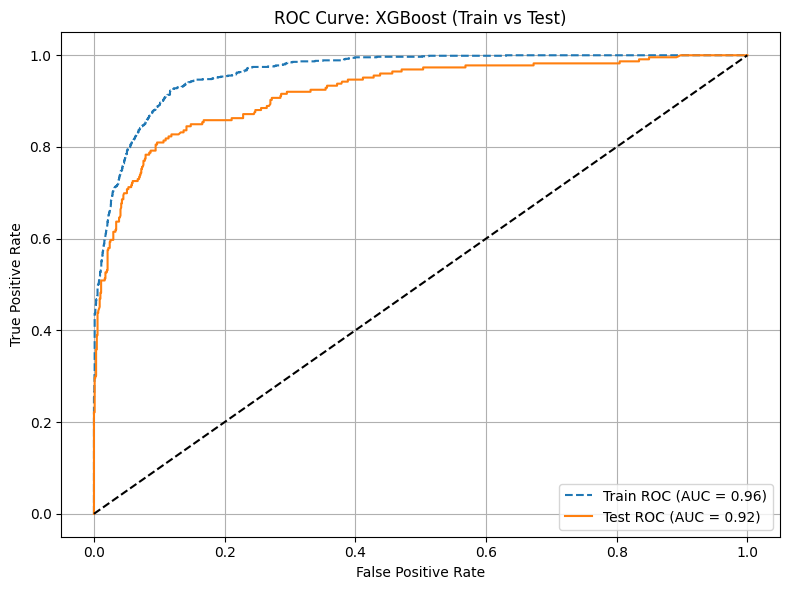

True Negatives (TN): 728
False Positives (FP): 183
False Negatives (FN): 32
True Positives (TP): 194
Expected Profit Decision Tree: 513


[05/08/25 18:27:33] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=496825;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=562284;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.03630680040949065

EMPC Fraction:  0.09060619880068399


In [24]:
# 1. Define parameter grid for tuning
param_grid = {
    'n_estimators':[100, 200, 1500],
    'max_depth':[4, 6, 8],
    'scale_pos_weight':[1, 4.16 ,10],
    'min_child_weight':[3, 5],
    'learning_rate':[0.1, 0.2],
    'subsample': [0.8, 1.0]
    }

# 2. Initialize base model with imbalance handling
xgb_base = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),
    random_state=42
)

# 3. GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# 4. Best estimator
best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV AUC:", grid_search.best_score_)

# 5. Predict on train & test
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

y_train_proba = best_xgb.predict_proba(X_train)[:, 1]
y_test_proba = best_xgb.predict_proba(X_test)[:, 1]

# 6. AUC
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 7. Train Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {auc_train:.4f}")

# 8. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {auc_test:.4f}")

# 9. ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: XGBoost (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Expected Profit
TN_xgb, FP_xgb, FN_xgb, TP_xgb = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_xgb}")
print(f"False Positives (FP): {FP_xgb}")
print(f"False Negatives (FN): {FN_xgb}")
print(f"True Positives (TP): {TP_xgb}")
exp_profit_xgb=TN_xgb-FN_xgb-FP_xgb
print(f"Expected Profit Decision Tree: {exp_profit_xgb}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

## Neural Network MLP

### Base Model

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3616   27]
 [  74  829]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3643
           1       0.97      0.92      0.94       903

    accuracy                           0.98      4546
   macro avg       0.97      0.96      0.96      4546
weighted avg       0.98      0.98      0.98      4546

Train ROC AUC Score: 0.9957

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[867  44]
 [ 63 163]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94       911
           1       0.79      0.72      0.75       226

    accuracy                           0.91      1137
   macro avg       0.86      0.84      0.85      1137
weighted avg       0.90      0.91      0.90      1137

Test ROC AUC Score: 0.9201


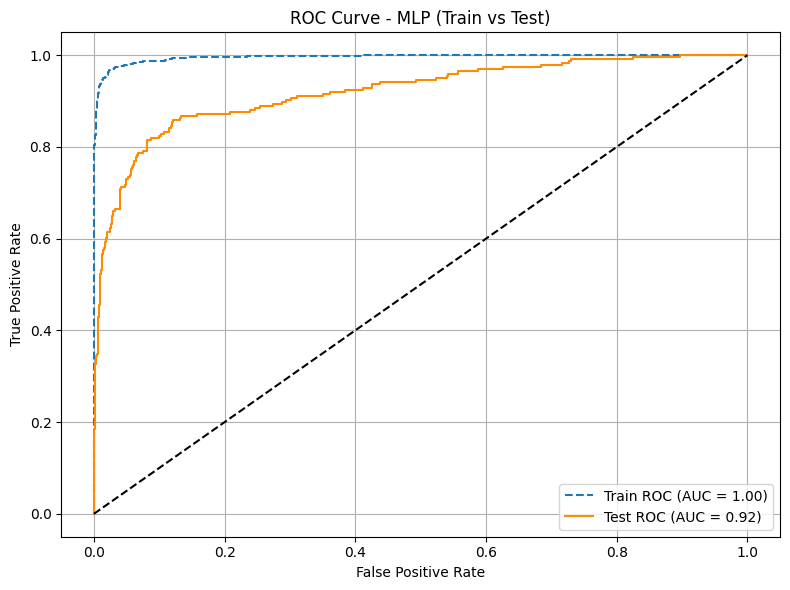

In [25]:
# 1. Initialize and Train the MLP model
MLP_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

MLP_model.fit(X_train, y_train)

# 2. Predict: Train and Test
y_train_pred = MLP_model.predict(X_train)
y_test_pred = MLP_model.predict(X_test)

y_train_proba = MLP_model.predict_proba(X_train)[:, 1]
y_test_proba = MLP_model.predict_proba(X_test)[:, 1]

# 3. AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 4. Evaluation: Train
print("===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 5. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 6. ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {auc_train:.2f})", linestyle='--')
plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {auc_test:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP (Train vs Test)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [ ]:
# 1. Define hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (64, 32), (128, 64), (128, 64, 32)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

# 2. GridSearchCV setup
mlp_base = MLPClassifier(
    max_iter=1000,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    scoring='recall',
    cv=10,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_mlp_model = grid_search.best_estimator_

print("\nBest Parameters Found:", grid_search.best_params_)

# 3. Predictions
y_train_pred = best_mlp_model.predict(X_train)
y_test_pred = best_mlp_model.predict(X_test)

y_train_proba = best_mlp_model.predict_proba(X_train)[:, 1]
y_test_proba = best_mlp_model.predict_proba(X_test)[:, 1]

# 4. AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 5. Evaluation: Train
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 6. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'MLP (AUC = {auc_test:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - MLP Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Expected Profit
TN_mlp, FP_mlp, FN_mlp, TP_mlp = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_mlp}")
print(f"False Positives (FP): {FP_mlp}")
print(f"False Negatives (FN): {FN_mlp}")
print(f"True Positives (TP): {TP_mlp}")
exp_profit_mlp=TN_mlp-FN_mlp-FP_mlp
print(f"Expected Profit MLP Classifier: {exp_profit_mlp}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

### Hyperparameter Tuning + SMOTE

In [ ]:
# 1. Define pipeline
smote_mlp_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# 2. Define hyperparameter grid
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(64,), (64, 32), (128, 64), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

# 3. Grid search
grid_smote_mlp = GridSearchCV(
    smote_mlp_pipeline,
    param_grid=param_grid_mlp,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 4. Fit model
grid_smote_mlp.fit(X_train, y_train)
best_mlp_smote = grid_smote_mlp.best_estimator_

# 5. Predictions
y_train_pred = best_mlp_smote.predict(X_train)
y_test_pred = best_mlp_smote.predict(X_test)

y_train_proba = best_mlp_smote.predict_proba(X_train)[:, 1]
y_test_proba = best_mlp_smote.predict_proba(X_test)[:, 1]

# 6. Training evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# 7. Test evaluation
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_smote_mlp.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 8. ROC curve: train vs test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_proba):.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SMOTE + Tuned MLPClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Class distribution check
X_res, y_res = best_mlp_smote.named_steps['smote'].fit_resample(X_train, y_train)
print("\nClass Distribution After SMOTE:")
print(pd.Series(y_res).value_counts())

# 10. Expected Profit
TN_mlp, FP_mlp, FN_mlp, TP_mlp = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_mlp}")
print(f"False Positives (FP): {FP_mlp}")
print(f"False Negatives (FN): {FN_mlp}")
print(f"True Positives (TP): {TP_mlp}")
exp_profit_mlp=TN_mlp-FN_mlp-FP_mlp
print(f"Expected Profit MLP Classifier: {exp_profit_mlp}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

### Hyperparameter Tuning + RUS

In [ ]:
# 1. Define pipeline
rus_mlp_pipeline = Pipeline([
    ('rus', RandomUnderSampler(random_state=42)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42))
])

# 2. GridSearchCV
grid_rus_mlp = GridSearchCV(
    rus_mlp_pipeline,
    param_grid=param_grid_mlp,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# 3. Fit model
grid_rus_mlp.fit(X_train, y_train)
best_mlp_rus = grid_rus_mlp.best_estimator_

# 4. Predictions
y_train_pred = best_mlp_rus.predict(X_train)
y_test_pred = best_mlp_rus.predict(X_test)

y_train_proba = best_mlp_rus.predict_proba(X_train)[:, 1]
y_test_proba = best_mlp_rus.predict_proba(X_test)[:, 1]

# 5. Training Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC: {roc_auc_score(y_train, y_train_proba):.4f}")

# 6. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Best Parameters:", grid_rus_mlp.best_params_)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC: {roc_auc_score(y_test, y_test_proba):.4f}")

# 7. ROC Curve: Train vs Test
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_proba):.2f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_proba):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - RUS + Tuned MLPClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Class distribution after RUS
X_res, y_res = best_mlp_rus.named_steps['rus'].fit_resample(X_train, y_train)
print("\nClass Distribution After RUS:")
print(pd.Series(y_res).value_counts())

# 9. Expected Profit
TN_mlp, FP_mlp, FN_mlp, TP_mlp = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_mlp}")
print(f"False Positives (FP): {FP_mlp}")
print(f"False Negatives (FN): {FN_mlp}")
print(f"True Positives (TP): {TP_mlp}")
exp_profit_mlp=TN_mlp-FN_mlp-FP_mlp
print(f"Expected Profit MLP Classifier: {exp_profit_mlp}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

## CatBoost

### Base Model


===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3591   52]
 [ 148  755]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      3643
           1       0.94      0.84      0.88       903

    accuracy                           0.96      4546
   macro avg       0.95      0.91      0.93      4546
weighted avg       0.96      0.96      0.96      4546

Train ROC AUC Score: 0.9867

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[877  34]
 [ 65 161]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95       911
           1       0.83      0.71      0.76       226

    accuracy                           0.91      1137
   macro avg       0.88      0.84      0.86      1137
weighted avg       0.91      0.91      0.91      1137

Test ROC AUC Score: 0.9364


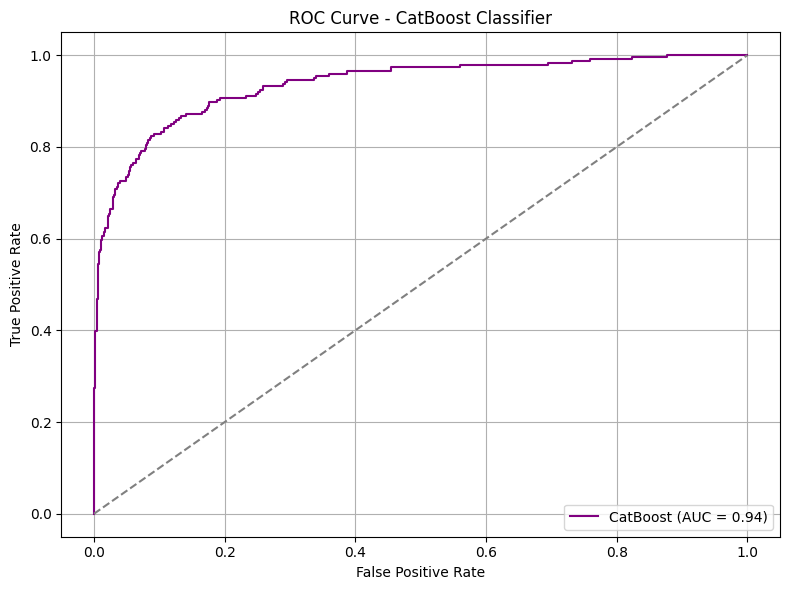

In [26]:
# 1. Initialize and train the CatBoost model
cat_model = CatBoostClassifier(
    verbose=0,
    auto_class_weights=None,
    random_state=42
)

cat_model.fit(X_train, y_train)

# 2. Predictions
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

y_train_proba = cat_model.predict_proba(X_train)[:, 1]
y_test_proba = cat_model.predict_proba(X_test)[:, 1]

# 3. AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 4. Evaluation: Train
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 5. Evaluation: Test
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 6. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_test:.2f})', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[05/08/25 18:28:45] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=697872;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=452414;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\sklearn\model_selection\_validation.py:540: FitFailedWarning:                       
                             360 fits failed out of a total of 720.                                                
                             The score on these train-test partitions for these parameters will be                 
                             set to nan.                                                                           
                             If these failures are not expected, you can try to debug them by                      
                             setting error_score='raise'.                                                          
                                                                                                                   
                             Below are more details about the failures:                                            
                             ----------------------------------------------------------------------                
                             ----------                                                                            
                             360 fits failed with the following error:                                             
                             Traceback (most recent call last):                                                    
                               File                                                                                
                             "C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packag                
                             es\sklearn\model_selection\_validation.py", line 888, in                              
                             _fit_and_score                                                                        
                                 estimator.fit(X_train, y_train, **fit_params)                                     
                               File                                                                                
                             "C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packag                
                             es\catboost\core.py", line 5245, in fit                                               
                                 self._fit(X, y, cat_features, text_features, embedding_features,                  
                             None, graph, sample_weight, None, None, None, None, baseline,                         
                             use_best_model,                                                                       
                               File                                                                                
                             "C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packag                
                             es\catboost\core.py", line 2395, in _fit                                              
                                 train_params = self._prepare_train_params(                                        
                                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^                                        
                               File                                                                                
                             "C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-packag                
                             es\catboost\core.py", line 2321, in _prepare_train_params                             
                                 _check_train_params(params)                          

                    WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=346890;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=522727;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in                 
                             cast                                                                                  
                               _data = np.array(data, dtype=dtype, copy=copy,                                      
                                                                                                                   

                    WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=407080;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=153582;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\sklearn\model_selection\_search.py:1103: UserWarning: One or more of                
                             the test scores are non-finite: [       nan        nan        nan                     
                             nan        nan        nan                                                             
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                                     nan        nan        nan        nan        nan        nan                    
                              0.90357906 0.9289941  0.90221477 0.92703664 0.9010497  0.92574257                    
                              0.92165576 0.94350745 0.92119545 0.94289123 0.92080056 0.94233878                    
                              0.90907103 0.93565468 0.90663463 0.93198334 0.90475443 0.92961606                    
                              0.92987178 0.94627323 0.92836296 0.94857706 0.92702125 0.94845794                    
                              0.91366114 0.94006266 0.90900261 0.93601637 0.90612894 0.93377473                    
                              0.93499421 0.94650658 0.93364899 0.94860844 0.9323615  0.94737321                    
                              0.90307519 0.92993654 0.90196108 0.92727438 0.90112037 0.92611534                    
                              0.9214175  0.94576069 0.92069494 0.94377689 0.92046964 0.94256197                    
                              0.90932783 0.93578099 0.90661746 0.93389976 0.90497114 0.93137226                    
                              0.9296668  0.95015408 0.92814599 0.94901424 0.92671961 0.94805275                    
                              0.9125899  0.94061796 0.90749069 0.93603415 0.90510368 0.93356818                    
                              0.93448435 0.94684322 0.93251629 0.94948926 0.93184841 0.9497789 ]                   
                               warnings.warn(                                                                      
                                                                                                                   


Best Parameters Found: {'auto_class_weights': 'Balanced', 'bootstrap_type': 'Bernoulli', 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.1}

===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3495  148]
 [   3  900]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      3643
           1       0.86      1.00      0.92       903

    accuracy                           0.97      4546
   macro avg       0.93      0.98      0.95      4546
weighted avg       0.97      0.97      0.97      4546

Train ROC AUC Score: 0.9973

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[831  80]
 [ 47 179]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       911
           1       0.69      0.79      0.74       226

    accuracy                           0.89      1137
   macro avg       0.82      0.85      0.83      1137
weig

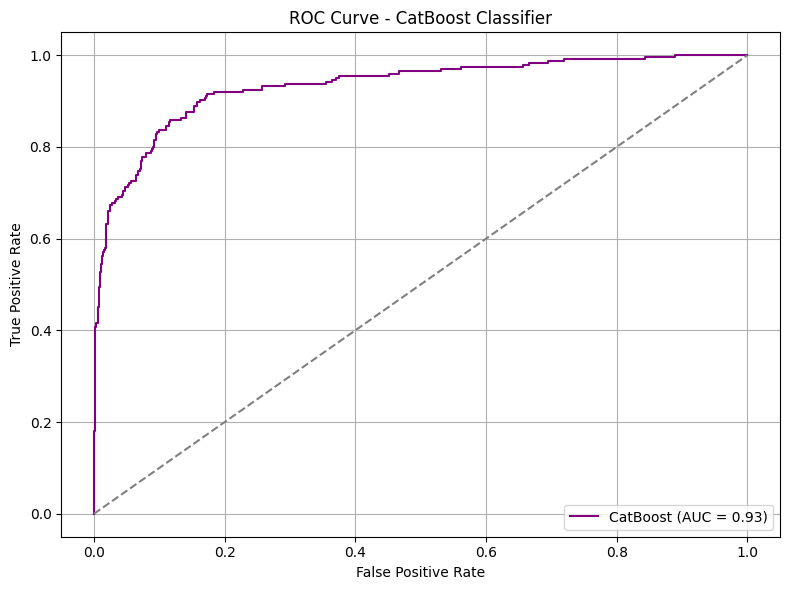

True Negatives (TN): 831
False Positives (FP): 80
False Negatives (FN): 47
True Positives (TP): 179
Expected Profit Light GBM : 704


[05/08/25 18:28:46] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=85825;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=341586;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.03779442002106506

EMPC Fraction:  0.0952428286081363


In [27]:
# 1. Define parameter grid
param_grid = {
    'iterations': [100, 300],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': [None, 'Balanced'],
    'bootstrap_type': ['Bayesian', 'Bernoulli'],
}

# 2. Set up base model
cb_base = CatBoostClassifier(
    verbose=0,
    random_state=42
)

# 3. GridSearchCV setup
grid_search = GridSearchCV(
    estimator=cb_base,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_cb_model = grid_search.best_estimator_

print("\nBest Parameters Found:", grid_search.best_params_)

# 4. Predictions
y_train_pred = best_cb_model.predict(X_train)
y_test_pred = best_cb_model.predict(X_test)

y_train_proba = best_cb_model.predict_proba(X_train)[:, 1]
y_test_proba = best_cb_model.predict_proba(X_test)[:, 1]

# 5. AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 6. Train Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 7. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 8. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_test:.2f})', color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CatBoost Classifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Expected Profit
TN_cat, FP_cat, FN_cat, TP_cat = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_cat}")
print(f"False Positives (FP): {FP_cat}")
print(f"False Negatives (FN): {FN_cat}")
print(f"True Positives (TP): {TP_cat}")
exp_profit_cat=TN_cat-FN_cat-FP_cat
print(f"Expected Profit Light GBM : {exp_profit_cat}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)

## Stacked Ensemble

### Base Model


===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3619   24]
 [  72  831]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3643
           1       0.97      0.92      0.95       903

    accuracy                           0.98      4546
   macro avg       0.98      0.96      0.97      4546
weighted avg       0.98      0.98      0.98      4546

Train ROC AUC Score: 0.9983

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[873  38]
 [ 60 166]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       911
           1       0.81      0.73      0.77       226

    accuracy                           0.91      1137
   macro avg       0.87      0.85      0.86      1137
weighted avg       0.91      0.91      0.91      1137

Test ROC AUC Score: 0.9334


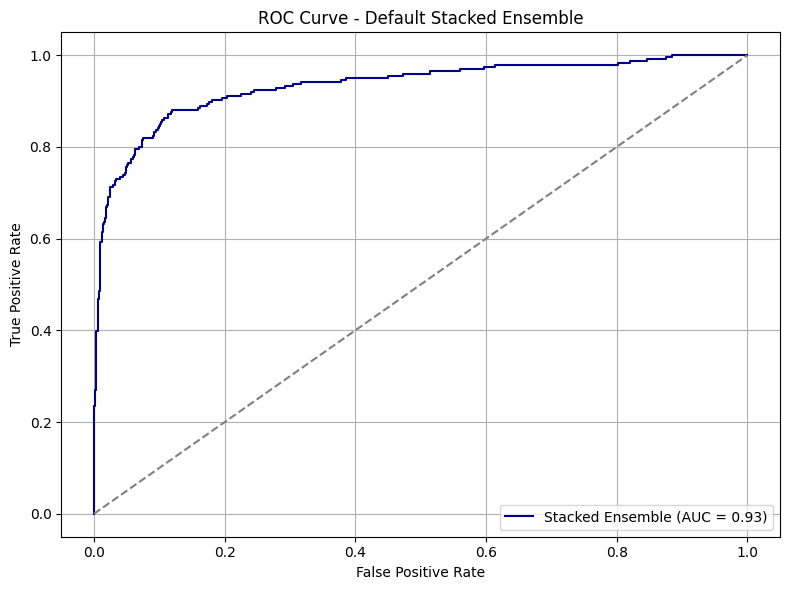

In [28]:
# 1. Define base learners
base_learners = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('mlp', MLPClassifier(max_iter=1000, random_state=42)),
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='auc', scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), random_state=42)),
    ('catboost', CatBoostClassifier(verbose=0, random_state=42))
]

# 2. Meta-learner
meta_learner = LogisticRegression(max_iter=1000, random_state=42)

# 3. Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# 4. Train the stacked model
stack_model.fit(X_train, y_train)

# 5. Predict
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

y_train_proba = stack_model.predict_proba(X_train)[:, 1]
y_test_proba = stack_model.predict_proba(X_test)[:, 1]

# 6. AUC Scores
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 7. Train Evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 8. Test Evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 9. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Stacked Ensemble (AUC = {auc_test:.2f})', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Default Stacked Ensemble")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

### Hyperparameter Tuning


===== TRAINING SET EVALUATION =====
Confusion Matrix:
 [[3402  241]
 [  19  884]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96      3643
           1       0.79      0.98      0.87       903

    accuracy                           0.94      4546
   macro avg       0.89      0.96      0.92      4546
weighted avg       0.95      0.94      0.95      4546

Train ROC AUC Score: 0.9945

===== TEST SET EVALUATION =====
Confusion Matrix:
 [[816  95]
 [ 31 195]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       911
           1       0.67      0.86      0.76       226

    accuracy                           0.89      1137
   macro avg       0.82      0.88      0.84      1137
weighted avg       0.91      0.89      0.89      1137

Test ROC AUC Score: 0.9349


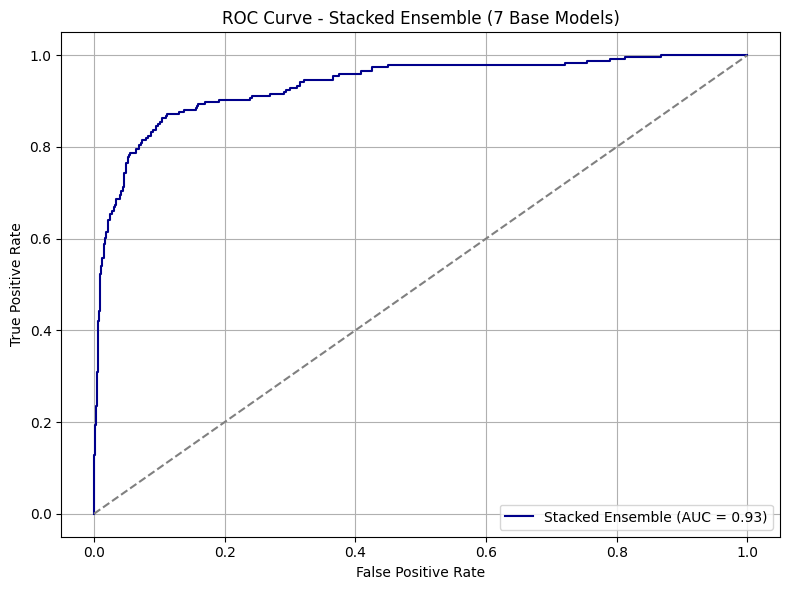

True Negatives (TN): 816
False Positives (FP): 95
False Negatives (FN): 31
True Positives (TP): 195
Expected Profit Stacked Ensemble : 690


[05/08/25 18:30:11] WARNING  C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=548169;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=738247;file://C:\Users\Ariq\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\EMP\metrics.py:154: RuntimeWarning: divide by zero encountered in                   
                             divide                                                                                
                               lambda_values = np.append(0, (((roc[3]*ROI) /                                       
                             roc[2])*(np.diff(roc[5]) / np.diff(roc[4]))))                                         
                                                                                                                   

******************************************************************************
EMP Credit Scoring Output
******************************************************************************
EMPC:  0.03888042205542253

EMPC Fraction:  0.0956125998891939


In [29]:
# 1. Define all base learners
base_learners = [
    ('lr', LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', solver='liblinear', max_iter=1000, random_state=42)),
    ('rf', RandomForestClassifier(class_weight='balanced', max_depth=10, max_features='sqrt', min_samples_leaf=5, min_samples_split=2, n_estimators=1500, random_state=42)),
    ('dt', DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=3, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, random_state=42)),
    ('mlp', MLPClassifier(activation='relu', alpha=0.0001, hidden_layer_sizes=(128, 64, 32), learning_rate='constant', solver='adam', random_state=42)),
    ('xgb', XGBClassifier(learning_rate=0.1, max_depth=4, min_child_weight=5, n_estimators=100, scale_pos_weight=10, subsample=1.0, random_state=42)),
    ('catboost', CatBoostClassifier(auto_class_weights='Balanced', bootstrap_type='Bayesian', depth=4, iterations=300, l2_leaf_reg=5, learning_rate=0.1, random_state=42, verbose=0))
]

# 2. Meta-learner
meta_learner = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# 3. Stacking Classifier setup
stack_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1,
    passthrough=True
)

# 4. Train the model
stack_model.fit(X_train, y_train)

# 5. Predict
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

y_train_proba = stack_model.predict_proba(X_train)[:, 1]
y_test_proba = stack_model.predict_proba(X_test)[:, 1]

# 6. ROC AUC
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

# 7. Train evaluation
print("\n===== TRAINING SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))
print(f"Train ROC AUC Score: {auc_train:.4f}")

# 8. Test evaluation
print("\n===== TEST SET EVALUATION =====")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print(f"Test ROC AUC Score: {auc_test:.4f}")

# 9. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Stacked Ensemble (AUC = {auc_test:.2f})', color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacked Ensemble (7 Base Models)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. Expected Profit
TN_sta, FP_sta, FN_sta, TP_sta = confusion_matrix(y_test, y_test_pred).ravel()
print(f"True Negatives (TN): {TN_sta}")
print(f"False Positives (FP): {FP_sta}")
print(f"False Negatives (FN): {FN_sta}")
print(f"True Positives (TP): {TP_sta}")
exp_profit_sta=TN_sta-FN_sta-FP_sta
print(f"Expected Profit Stacked Ensemble : {exp_profit_sta}")
emp_result = empCreditScoring(y_test_proba, y_test, print_output=True)